In [1]:
import picamera
import time
from IPython.display import Image
import math
import serial
import socket
import re
import cv2 as cv

In [2]:
IMAGES_PATH = "images/"
utils = "Utils/"

bottle_cascade = cv.CascadeClassifier(utils + 'biggest_haar.xml')

In [3]:
''''''
''' TCP COMMUNICATION '''
''''''

def enable_tcp_com(BUFFER_SIZE):
    TCP_IP = '192.168.43.58' 
    TCP_PORT = 5005
    while(1):
        try:
            s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            s.connect((TCP_IP, TCP_PORT))
            s.setblocking(0)
        except:
            continue
        else:
            print("TCP com enabled!")
            break

    return s

def send_message(s, msg):
    s.send((msg).encode())
    
def check_data_received(s, msg, BUFFER_SIZE):
    ready = select.select([s], [], [], 0.2)
    print(ready)
    if ready[0]:
        data = s.recv(BUFFER_SIZE)
        print(data.decode())
        return data.decode()[-9:] == msg
    else :
        print("Data was not received")
        return None

def close_connection(s):
    s.close()

''''''
''' Robot position '''
''''''


def open_ser():
    ser = serial.Serial(
        port='../../../dev/ttyS0', #Replace ttyS0 with ttyAM0 for Pi1,Pi2,Pi0
        baudrate = 115200,
        parity=serial.PARITY_NONE,
        stopbits=serial.STOPBITS_ONE,
        bytesize=serial.EIGHTBITS,
        timeout=1
    )
    return ser

def get_robot_pos_angle(ser):
    buffer = ''
    ser.flushInput()
    time.sleep(0.1)
    timeout = time.time() + 5 #5s timeout
    while True:
        # last_received = ser.readline()
        buffer += str(ser.read(ser.inWaiting()))
        
        if len(buffer.split('\\n')) >= 3:
            last_received = buffer.split('\\n')[-2]
            pos_angle = re.findall('[+-]?\d+\.\d+', last_received )
            if len(pos_angle) == 3:
                return pos_angle[0], pos_angle[1], pos_angle[2]
        if time.time() > timeout:
            return -1, -1, -1
            break


''''''
''' Bottle position '''
''''''

def calcul_object_pos(xr,yr,ar,dist_rb,a_rb):
    ab = ar + a_rb

    rel_xb = dist_rb * math.cos(math.radians(ab))
    rel_yb = dist_rb * math.sin(math.radians(ab))
    
    real_xb = xr + rel_xb
    real_yb = yr + rel_yb
    return real_xb,real_yb


def calcul_low_center(x,y,w,h):
    return (x+w/2), (y+h)

def multiDimenDist(point1,point2):
   #find the difference between the two points, its really the same as below
    deltaVals = [point2[dimension]-point1[dimension] for dimension in range(len(point1))]
    runningSquared = 0
   #because the pythagarom theorm works for any dimension we can just use that
    for coOrd in deltaVals:
        runningSquared += coOrd**2
    return runningSquared**(1/2)

def findVec(point1,point2,unitSphere = False):
    #setting unitSphere to True will make the vector scaled down to a sphere with a radius one, instead of it's orginal length
    finalVector = [0 for coOrd in point1]
    for dimension, coOrd in enumerate(point1):
        #finding total differnce for that co-ordinate(x,y,z...)
        deltaCoOrd = point2[dimension]-coOrd
        #adding total difference
        finalVector[dimension] = deltaCoOrd
    if unitSphere:
        totalDist = multiDimenDist(point1,point2)
        unitVector =[]
        for dimen in finalVector:
            unitVector.append( dimen/totalDist)
            return unitVector
    else:
        return finalVector

def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def calcul_angle(v1, v2):
    return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

def calcul_bottle_dist_angle(center, img_width, img_height):
    vect1 = findVec([img_width/2, img_height],[img_width/2, 0])
    vect2 = findVec([img_width/2, img_height],[center[0],center[1]])
    angle_br = math.degrees(calcul_angle(vect1,vect2))*0.7
    if center[0] > img_width/2:
        angle_br = -angle_br
    dist_y = 20546*(center[1]**(-1.279))
    dist = dist_y / math.cos(math.radians(angle_br))
    return dist, angle_br

# Main

In [4]:
BUFFER_SIZE = 1024
s = enable_tcp_com(BUFFER_SIZE)

TCP com enabled!


In [5]:
camera = picamera.PiCamera()
camera.rotation = 180
camera.resolution = (504, 336)

In [6]:
ser = open_ser()

In [7]:
font = cv.FONT_HERSHEY_SIMPLEX
fontScale = 1
fontColor = (255,255,255)
lineType = 2


In [8]:
get_robot_pos_angle(ser)

('840.24', '346.23', '100.58')

In [ ]:
while(True):
    robot_x, robot_y, robot_a = get_robot_pos_angle(ser)
    robot_x = float(robot_x)/10
    robot_y = float(robot_y)/10
    robot_a = float(robot_a)
    '''robot_x= 400
    robot_y = 400
    robot_a = 90'''

    camera.capture(IMAGES_PATH + "cam.bmp")
    img = cv.imread(IMAGES_PATH + 'cam.bmp')

    # resize to increase speed detection
    img_height,img_width = img.shape[:2]   

    bottles = bottle_cascade.detectMultiScale(img, minNeighbors=18)
    tcp_msg = ""
    msg_to_send = False
    bottle_x = []
    bottle_y = []
    i = 0

    for (x,y,w,h) in bottles:
        cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        bottomLeftCornerOfText = (x-10,y-10)
        cv.putText(img,str(i), bottomLeftCornerOfText,font,fontScale,fontColor,lineType)
        center = calcul_low_center(x,y,w,h)
        bottle_dist, bottle_a = calcul_bottle_dist_angle(center, img_width, img_height)
        if bottle_dist < 400:
            cx, cy = calcul_object_pos(robot_x, robot_y, robot_a, 40, bottle_a)
            xb, yb = calcul_object_pos(cx, cy, robot_a, bottle_dist, bottle_a)
            if (xb < 350 and yb > 450) or (xb > 480 and yb > 580) or (xb < 200 and yb < 200) or xb < 10 or yb < 10 or xb > 790 or yb > 790:
                continue
            else:
                msg_to_send = True
                bottle_x.append(int(round(xb)))
                bottle_y.append(int(round(yb)))
        else:
            continue
        i = i + 1
    if msg_to_send:
        msg_to_send = False
        for i in range(0, len(bottle_x)):
            tcp_msg = tcp_msg + "(" + str(bottle_x[i])+ "," + str(bottle_y[i]) + ");"
        print(("Robot's position: ({},{}), angle: {}").format(robot_x,robot_y,robot_a))
        print(("Bottle's position: {}").format(tcp_msg))
        send_message(s, tcp_msg )
    

cv.imwrite(IMAGES_PATH + "cam_haar.png", img)
Image(filename = IMAGES_PATH + 'cam_haar.png')

Robot's position: (341.995,251.04699999999997), angle: -319.58
Bottle's position: (429,396);
Robot's position: (381.31399999999996,284.94899999999996), angle: -319.9
Bottle's position: (450,420);
Robot's position: (392.839,294.313), angle: -321.93
Bottle's position: (459,431);
Robot's position: (395.87199999999996,296.688), angle: -322.14
Bottle's position: (458,427);
Robot's position: (395.87199999999996,296.688), angle: -322.14
Bottle's position: (466,439);
Robot's position: (395.87199999999996,296.688), angle: -322.14
Bottle's position: (465,437);
Robot's position: (454.451,368.511), angle: 111.24
Bottle's position: (444,523);
Robot's position: (429.86199999999997,409.089), angle: 123.89
Bottle's position: (413,551);(414,572);
Robot's position: (428.605,411.004), angle: 122.4
Bottle's position: (416,566);
Robot's position: (428.61,410.997), angle: 122.4
Bottle's position: (416,569);
Robot's position: (428.61,410.997), angle: 122.4
Bottle's position: (415,571);
Robot's position: (440

# Haar test

In [18]:
start = time.time()
camera.capture(IMAGES_PATH + "cam.bmp")
img = cv.imread(IMAGES_PATH + 'cam.bmp')
print(time.time() - start)

0.5370090007781982


In [19]:
img_height, img_width = img.shape[:2] 
img.shape[:2] 
print("({},{})".format(img_width,img_height))

(504,336)


In [16]:
#bottle_cascade = cv.CascadeClassifier(utils + 'haar_bottle_20_more_pos.xml')
bottle_cascade = cv.CascadeClassifier(utils + 'biggest_haar.xml')

time: 1.0871467590332031
0 angle: -7.411124922766009
0 dist: 44.454562083623266
(292.0, 122)
1 angle: 25.90747126352218
1 dist: 89.77701035523128
(56.0, 76)
2 angle: 32.197039528100845
2 dist: 51.021979557088386
(32.5, 124)
3 angle: 22.4778620938611
3 dist: 67.50761712565819
(99.5, 93)
4 angle: -20.063703328819383
4 dist: 38.30387638814683
(357.5, 143)
5 angle: -8.851794277573081
5 dist: 27.129224892794664
(287.0, 180)


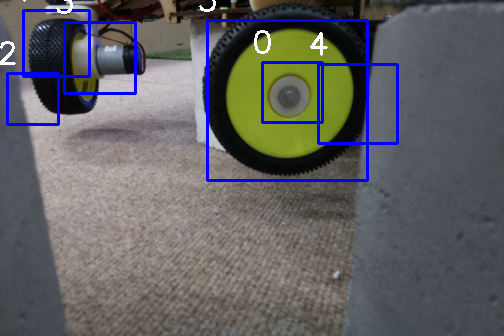

In [17]:
start_time = time.time()
bottles = bottle_cascade.detectMultiScale(img, minNeighbors=6)
print("time: " + str(time.time() - start_time))
i = 0
for (x,y,w,h) in bottles:
    font = cv.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (x-10,y-10)
    fontScale = 1
    fontColor = (255,255,255)
    lineType = 2
    cv.putText(img,str(i), bottomLeftCornerOfText,font,fontScale,fontColor,lineType)
    center = calcul_low_center(x,y,w,h)
    dist, angle = calcul_bottle_dist_angle(center, img_width, img_height)
    print(str(i) + " angle: " + str(angle))
    print(str(i) + " dist: " + str(dist))
    print(center)
    cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    i = i + 1

cv.imwrite(IMAGES_PATH + "cam_haar.png", img)
Image(filename = IMAGES_PATH + 'cam_haar.png')

In [48]:
import datetime
def record_video():
    filename = "recording_" + str(datetime.datetime.now().strftime("%Y%m%d_%H%M%S")) + ".h264"
    camera.start_preview()
    camera.start_recording(filename)

def finish_video():
    camera.stop_recording()
    camera.stop_preview()

record_video()
time.sleep(60)
finish_video()

# Close connection and camera

In [11]:
camera.close()

In [9]:
close_connection(s)